# پروژه پیش‌بینی قیمت آپارتمان در تهران

در این نوت‌بوک مراحل بارگذاری داده، تحلیل اکتشافی، پیش‌پردازش، مدل‌سازی رگرسیونی و ارزیابی مدل برای تخمین قیمت آپارتمان‌های تهران را انجام می‌دهیم.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['font.size'] = 11


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)


## بارگذاری داده‌ها

In [2]:
df = pd.read_csv('housePrice.csv')
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1850000000,61666.67
1,60,1,True,True,True,Shahran,1850000000,61666.67
2,79,2,True,True,True,Pardis,550000000,18333.33
3,95,2,True,True,True,Shahrake Qods,902500000,30083.33
4,123,2,True,True,True,Shahrake Gharb,7000000000,233333.33


## اطلاعات اولیه و بررسی مقادیر گمشده

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3479 non-null   object 
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   bool   
 3   Warehouse   3479 non-null   bool   
 4   Elevator    3479 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price       3479 non-null   int64  
 7   Price(USD)  3479 non-null   float64
dtypes: bool(3), float64(1), int64(2), object(2)
memory usage: 146.2+ KB


In [4]:
df.describe(include='all')

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
count,3479,3479.000000,3479,3479,3479,3456,3.479000e+03,3.479000e+03
unique,243,NaN,2,2,2,192,NaN,NaN
top,75,NaN,True,True,True,Punak,NaN,NaN
freq,111,NaN,2950,3182,2739,161,NaN,NaN
mean,NaN,2.079908,NaN,NaN,NaN,NaN,5.359023e+09,1.786341e+05
std,NaN,0.758275,NaN,NaN,NaN,NaN,8.099935e+09,2.699978e+05
min,NaN,0.000000,NaN,NaN,NaN,NaN,3.600000e+06,1.200000e+02
25%,NaN,2.000000,NaN,NaN,NaN,NaN,1.418250e+09,4.727500e+04
50%,NaN,2.000000,NaN,NaN,NaN,NaN,2.900000e+09,9.666667e+04
75%,NaN,2.000000,NaN,NaN,NaN,NaN,6.000000e+09,2.000000e+05


In [5]:
df.isnull().sum()

Area           0
Room           0
Parking        0
Warehouse      0
Elevator       0
Address       23
Price          0
Price(USD)     0
dtype: int64

### تحلیل اولیه

- تعداد ردیف‌ها و نوع داده هر ستون در خروجی `info()` مشخص شد.
- با `isnull().sum()` تعداد مقادیر گمشده هر ستون را دیدیم.
- طبق خروجی، ستون Address برای تعدادی از ردیف‌ها مقدار ندارد، که در مرحله پیش‌پردازش مدیریت می‌کنیم.


## تبدیل ستون‌های عددی به نوع عددی (حذف کاما)


In [25]:
# حذف کاما و تبدیل به float
df['Price'] = df['Price'].astype(str).str.replace(',', '').astype(float)
df['Price(USD)'] = df['Price(USD)'].astype(str).str.replace(',', '').astype(float)
df['Area'] = df['Area'].astype(str).str.replace(',', '').astype(float)

df.dtypes

Area          float64
Room            int64
Parking          bool
Warehouse        bool
Elevator         bool
Address        object
Price         float64
Price(USD)    float64
dtype: object

## ویژوالایز هیستوگرام تمام ویژگی‌ها

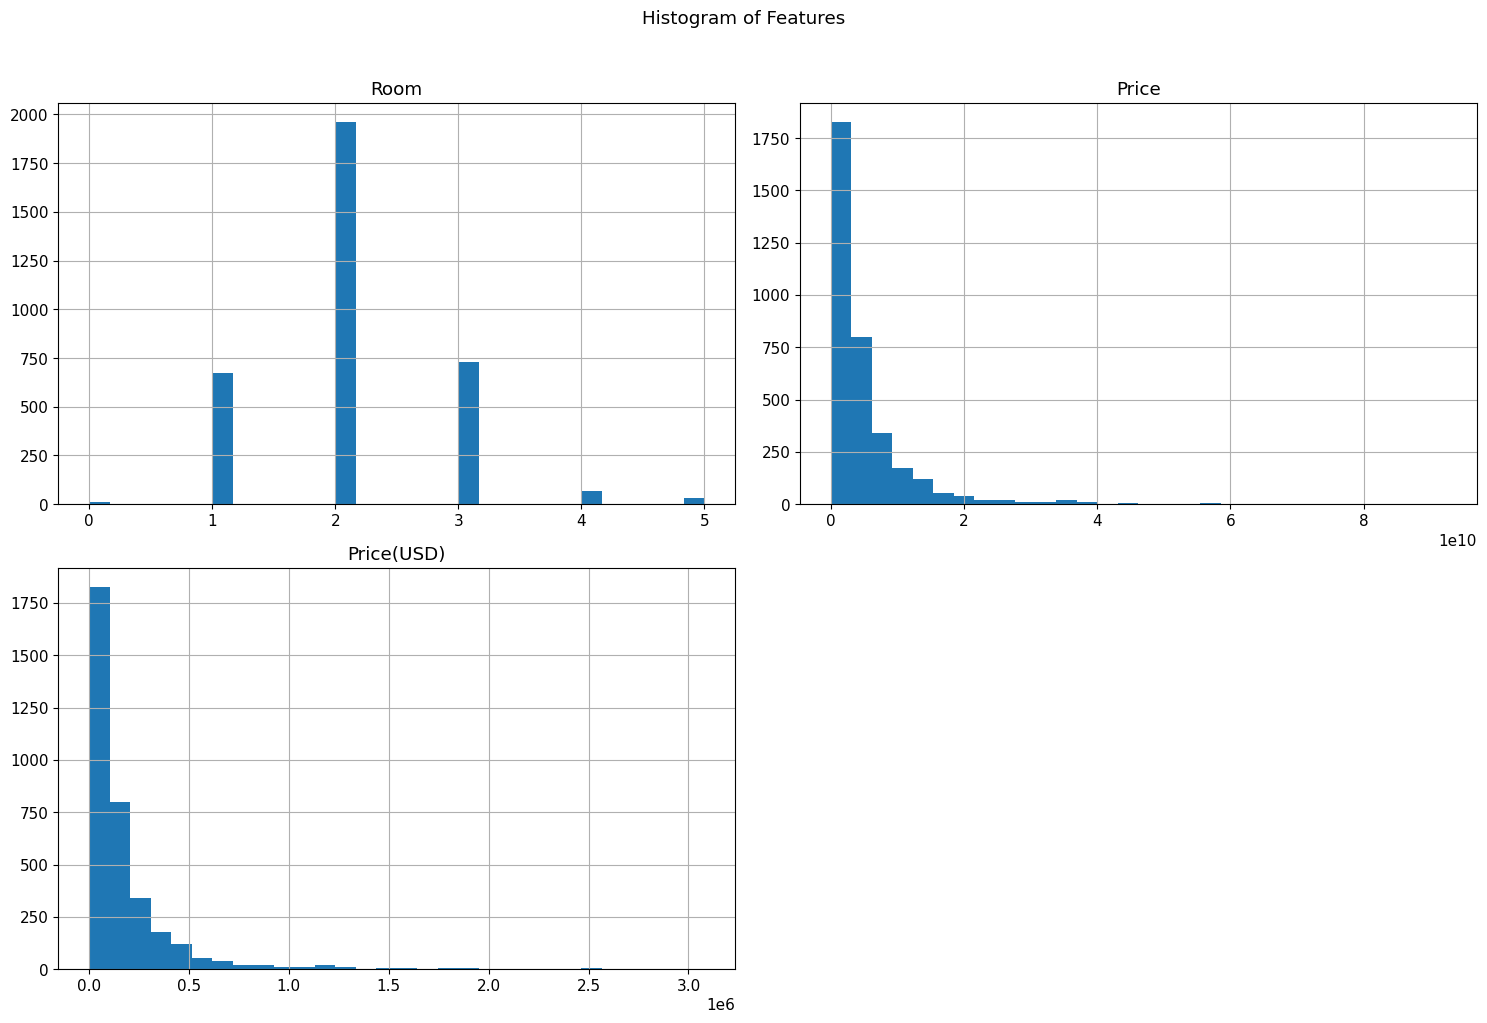

In [8]:
df.hist(bins=30, figsize=(15, 10))
plt.suptitle("Histogram of Features", y=1.02)
plt.tight_layout()
plt.show()

### تحلیل هیستوگرام‌ها

- توزیع `Area` راست‌چوله است (بیشتر آپارتمان‌ها متراژ کم دارند و چند مقدار خیلی بزرگ وجود دارد) که نشان‌دهنده وجود داده‌های پرت در متراژ است.
- توزیع `Price` نیز راست‌چوله است و تعداد کمی آپارتمان با قیمت بسیار بالا وجود دارد.
- تعداد اتاق (`Room`) مقادیر گسسته دارد و بیشترین فراوانی مربوط به ۱ و ۲ اتاق است.
- متغیرهای `Parking`، `Warehouse` و `Elevator` دودویی هستند و نسبت خانه‌هایی که این امکانات را دارند مشخص است.
  
بر اساس شکل هیستوگرام `Area` متوجه می‌شویم که قبل از مدل‌سازی باید داده‌های پرت (متراژهای خیلی بزرگ) را شناسایی و حذف کنیم.


## بررسی همبستگی ویژگی‌ها با قیمت


In [26]:
numeric_cols = ['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Price']  # اگر Price(USD) هم خواستی اضافه کن
corr = df[numeric_cols].corr()

corr

,Area,Room,Parking,Warehouse,Elevator,Price
Area,1.000000,0.016409,0.011751,0.008447,0.014398,0.021086
Room,0.016409,1.000000,0.274277,0.129581,0.180371,0.567994
Parking,0.011751,0.274277,1.000000,0.433244,0.430614,0.190774
Warehouse,0.008447,0.129581,0.433244,1.000000,0.203970,0.109069
Elevator,0.014398,0.180371,0.430614,0.203970,1.000000,0.111330
Price,0.021086,0.567994,0.190774,0.109069,0.111330,1.000000


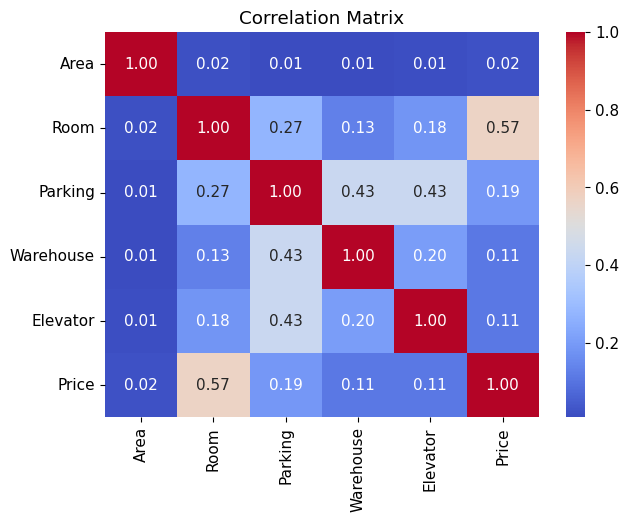

In [16]:
plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

### تحلیل همبستگی

- متغیر `Area` همبستگی مثبت نسبتاً بالایی با `Price` دارد، بنابراین انتظار داریم متراژ نقش مهمی در قیمت داشته باشد.
- تعداد اتاق (`Room`) نیز تا حدی با `Price` مرتبط است.
- امکاناتی مانند `Parking`، `Warehouse` و `Elevator` همبستگی ضعیف‌تری دارند اما می‌توانند در مدل چندمتغیره کمک کنند.
- در این پروژه آدرس را به صورت مستقیم وارد ماتریس همبستگی نمی‌کنیم، چون یک ویژگی کیفی (categorical) است.


## بررسی داده‌های پرت در متراژ و قیمت


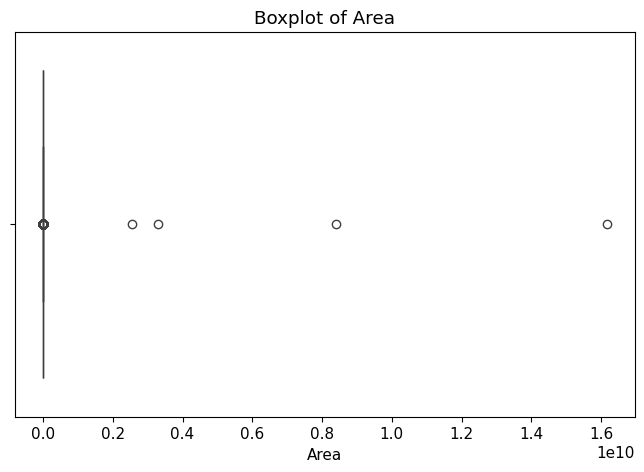

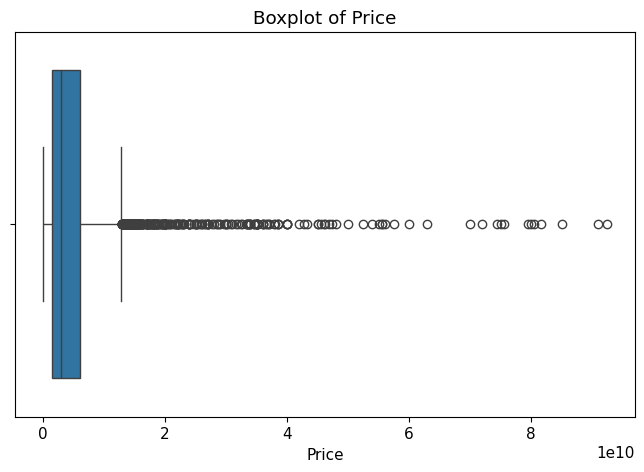

In [17]:
plt.figure()
sns.boxplot(x=df['Area'])
plt.title("Boxplot of Area")
plt.show()

plt.figure()
sns.boxplot(x=df['Price'])
plt.title("Boxplot of Price")
plt.show()

### تحلیل Boxplot

- در Boxplot مربوط به `Area` چند مقدار بسیار بزرگ دیده می‌شود که به احتمال زیاد ناشی از ثبت اشتباه هستند.
- برای حذف این داده‌های پرت از روش IQR (بین‌چارکی) استفاده می‌کنیم تا یک آستانه منطقی برای متراژها تعیین شود.


## حذف داده‌های پرت متراژ با استفاده از IQR


In [27]:
Q1 = df['Area'].quantile(0.25)
Q3 = df['Area'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Q1:", Q1)
print("Q3:", Q3)
print("IQR:", IQR)
print("Lower bound:", lower_bound)
print("Upper bound:", upper_bound)

print("تعداد ردیف‌ها قبل از حذف:", df.shape[0])

df_clean = df[(df['Area'] >= lower_bound) & (df['Area'] <= upper_bound)]

print("تعداد ردیف‌ها بعد از حذف:", df_clean.shape[0])

Q1: 69.0
Q3: 121.0
IQR: 52.0
Lower bound: -9.0
Upper bound: 199.0
تعداد ردیف‌ها قبل از حذف: 3456
تعداد ردیف‌ها بعد از حذف: 3219


با استفاده از IQR محدوده منطقی متراژها را محاسبه کردیم و ردیف‌هایی که بیرون از این محدوده بودند به عنوان داده پرت حذف شدند.  
به این ترتیب به‌جای انتخاب دل‌خواه یک عدد مثل 1000، بر اساس آمار توصیفی (IQR) تصمیم گرفتیم.
از این به بعد با دیتافریم `df_clean` کار می‌کنیم.


## مدیریت ستون Address

ستون `Address` یک متغیر کیفی (categorical) بدون ترتیب است.  
کدگذاری آن با `LabelEncoder` باعث ایجاد ترتیب مصنوعی بین محله‌ها می‌شود و می‌تواند روی مدل رگرسیون خطی تأثیر منفی بگذارد.  
همچنین تعداد محله‌ها زیاد است و کدگذاری آن‌ها مدل را پیچیده می‌کند.  
به همین دلیل در این پروژه، برای سادگی و پایبندی به رگرسیون خطی کلاسیک، ستون `Address` را در مدل رگرسیونی استفاده نمی‌کنیم.


## مدل ۱: رگرسیون خطی ساده (Price بر حسب Area)


In [20]:
X_area = df_clean[['Area']].values  # ویژگی
y_price = df_clean['Price'].values  # هدف

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(
    X_area, y_price, test_size=0.2, random_state=42
)

lin_reg_area = LinearRegression()
lin_reg_area.fit(X_train_a, y_train_a)

y_pred_a = lin_reg_area.predict(X_test_a)

print("ضریب (slope):", lin_reg_area.coef_[0])
print("عرض از مبدأ:", lin_reg_area.intercept_)


ضریب (slope): 84585726.79247764
عرض از مبدأ: -3945497696.454854


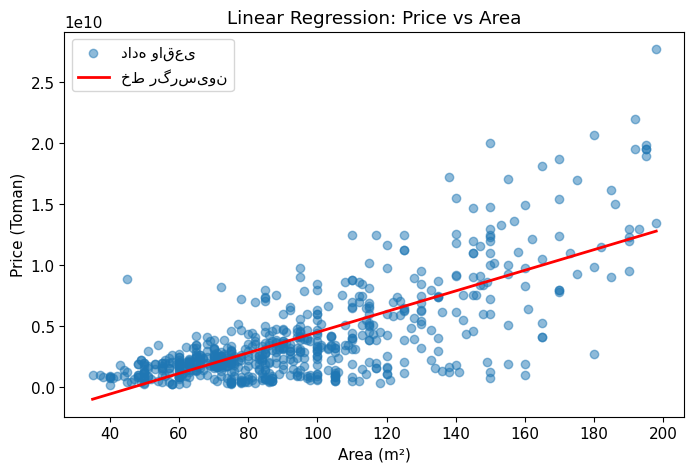

In [28]:
plt.figure()
plt.scatter(X_test_a, y_test_a, alpha=0.5, label="داده واقعی")

# مرتب‌سازی برای رسم خط صاف
sorted_idx = X_test_a[:, 0].argsort()
plt.plot(X_test_a[sorted_idx], y_pred_a[sorted_idx], linewidth=2, label="خط رگرسیون", color='red')

plt.xlabel("Area (m²)")
plt.ylabel("Price (Toman)")
plt.title("Linear Regression: Price vs Area")
plt.legend()
plt.show()

In [29]:
# متریک‌های تست
mse_test_a = mean_squared_error(y_test_a, y_pred_a)
rmse_test_a = np.sqrt(mse_test_a)
mae_test_a = mean_absolute_error(y_test_a, y_pred_a)
r2_test_a = r2_score(y_test_a, y_pred_a)

# متریک‌های train
y_train_pred_a = lin_reg_area.predict(X_train_a)
rmse_train_a = np.sqrt(mean_squared_error(y_train_a, y_train_pred_a))

print("Train RMSE:", rmse_train_a)
print("Test RMSE:", rmse_test_a)
print("Test MAE:", mae_test_a)
print("Test R2:", r2_test_a)

Train RMSE: 2646600437.706347
Test RMSE: 2689060891.0763116
Test MAE: 1865897006.5589046
Test R2: 0.543851175605983


### ارزیابی مدل رگرسیون ساده

- `R2` نشان می‌دهد چه نسبتی از واریانس قیمت توسط متراژ توضیح داده می‌شود.
- `RMSE` و `MAE` خطای متوسط مدل روی داده‌های تست را نشان می‌دهند.
- با مقایسه `Train RMSE` و `Test RMSE` می‌بینیم که این دو مقدار خیلی از هم دور نیستند، بنابراین مدل دچار بیش‌برازش (overfitting) شدید نشده است.
- از نمودار اسکتر و خط رگرسیون مشخص است که رابطه کلی مثبت بین متراژ و قیمت وجود دارد، اما به دلیل نقش ویژگی‌های دیگر (محله، امکانات و...) پراکندگی دیده می‌شود.


## مدل ۲: رگرسیون خطی چندمتغیره با چند ویژگی


In [30]:
feature_cols = ['Area', 'Room', 'Parking', 'Warehouse', 'Elevator']

X = df_clean[feature_cols].astype(float)
y = df_clean['Price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

lin_reg_multi = LinearRegression()
lin_reg_multi.fit(X_train, y_train)

y_pred = lin_reg_multi.predict(X_test)

coeff_df = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': lin_reg_multi.coef_
})
coeff_df

,feature,coefficient
0,Area,9.401524e+07
1,Room,-8.074309e+08
2,Parking,5.464165e+08
3,Warehouse,3.348087e+08
4,Elevator,1.991306e+08


In [31]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R2:", r2)

MSE: 7.065447198346407e+18
RMSE: 2658090893.544915
MAE: 1828332092.3206606
R2: 0.5542976313769775


### ارزیابی مدل چندمتغیره

- با اضافه کردن ویژگی‌های `Room`، `Parking`، `Warehouse` و `Elevator` دقت مدل نسبت به مدل یک‌بعدی بهتر شده (مقایسه `R2` و `RMSE` با مدل قبلی).
- ضرایب مدل نشان می‌دهند که افزایش هر ویژگی، در صورت ثابت بودن بقیه، چه تأثیری تقریبی روی قیمت دارد.
- همچنان بخشی از واریانس قیمت توسط عواملی مثل محله (Address) و شرایط بازار توضیح داده می‌شود که در این مدل لحاظ نشده‌اند.


## جمع‌بندی نهایی

در این پروژه با استفاده از داده‌های واقعی حدود ۴۰۰۰ آپارتمان در تهران:

1. داده‌ها را بارگذاری و مقادیر گمشده و نوع داده‌ها را بررسی کردیم.
2. با استفاده از هیستوگرام‌ها و Boxplot، وجود داده‌های پرت در متراژ (`Area`) را شناسایی کردیم.
3. با روش IQR داده‌های پرت متراژ را حذف کردیم تا مدل روی داده‌های منطقی‌تر آموزش ببیند.
4. ستون‌های `Price` و `Price(USD)` را از حالت رشته‌ای (با کاما) به نوع عددی تبدیل کردیم.
5. با ماتریس همبستگی متوجه شدیم که متراژ و تعداد اتاق بیشترین تأثیر را روی قیمت دارند.
6. یک مدل رگرسیون خطی ساده (Price ~ Area) ساختیم، خط رگرسیون را روی نقاط اسکتر رسم کردیم و با متریک‌های `RMSE`، `MAE` و `R2` آن را ارزیابی کردیم و بیش‌برازش را بررسی نمودیم.
7. یک مدل رگرسیون چندمتغیره با ویژگی‌های `Area`، `Room`، `Parking`، `Warehouse` و `Elevator` ساختیم و نشان دادیم که این مدل نسبت به مدل ساده دقت بیشتری دارد.

در مجموع، متراژ مهم‌ترین عامل در تعیین قیمت است، اما امکانات و سایر ویژگی‌ها نیز در بهبود مدل نقش دارند.
